# Info 3950 Problem Set 8

**due Wed evening 10 May 2023 23:00 (or auto-extension to Fri)**

Remember to include your name and netid in the first cell. Submit via [gradescope](https://gradescope.com/).

<font size="-1">[Also note that these problem sets are not intended as group projects: the work you submit must be your own. You can discuss with other students at a high level, for example general methods or strategies to solve a problem, but you must cite the other student(s) in your submission. Any work you submit must be your own understanding of the solution, the details of which you personally and individually worked out, and written in your own words. In no cases should notebooks or code be shared.]</font>

### <font color='red'>Alex Weseley alw269</font>

In [1]:
import torch, torch.nn as nn, torch.nn.functional as F, numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# 1)  

This problem draws heavily from the parts of the Karpathy video ["build GPT: from scratch"](https://www.youtube.com/watch?v=kCc8FmEb1nY) covered in [lec27_torch_tran.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2023sp/lec27_torch_tran.ipynb), and as well from an earlier video ["makemore Part 2: MLP"](https://www.youtube.com/watch?v=TCH_1BHY58I)
Using the directions in the problem, it won't be necessary to watch either video, but they do contain much useful additional explanation, and have linked notebooks with code you can adapt. (The problems here are sufficiently different that you'll have to understand how the code works regardless.)

The first part of this problem uses Karpathy's [names.txt](https://raw.githubusercontent.com/karpathy/makemore/master/names.txt), which should download to disk. It contains 32033 lowercased first names to model:

In [2]:
# read in all the words, I called it ak_names.txt, call it what you like
words = open('names.txt', 'r').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words)))) # 26 characters
stoi = {s:i+1 for i,s in enumerate(chars)}  # string to integer conversion
stoi['.'] = 0  # add in '.' for padding and for end of name
itos = {i:s for s,i in stoi.items()}  # integer back to string
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


He build a dataset of character n-grams to train on with this function:

In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [5]:
# import random
# random.seed(42)
# random.shuffle(words)  #instead use in original order

n1 = int(0.8*len(words)) #80% train
n2 = int(0.9*len(words)) #10% validation / dev

X_train, y_train = build_dataset(words[:n1]) #80%
X_dev, y_dev = build_dataset(words[n1:n2])  #10%
X_test, y_test = build_dataset(words[n2:])  #10%

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


and uses the first 80% as training set, the next 10% as dev/validation set, and the final 10% as test set.<br>
This is more careful than we've been, where the 10% validation is used to tune the network, select learning rate, etc., before assessing on the real test data (that hasn't been seen). Here we'll use the parameters that he finetuned (see video "makemore Part 2: MLP" for methodology), so the validation set won't play a direct role (but still useful to know that the test set was not used in selecting the parameters for the model).

The first twelve training examples produced by the `build_dataset()` code above are as follows:

In [6]:
X_train[:12], y_train[:12]

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0]))

and by translating back to the original text (below), you can see that each training example is a 3 character sequence, and the associated training label is the next character after that sequence within a name (i.e., the target  we're trying to predict). Each name is padded with '...' at the beginning, and '.' at the end, so it can start prediction from the begining of name, and can predict where the end will be:

In [7]:
for i in range(12):
    print (''.join(itos[i.item()] for i in X_train[i]), '->', itos[y_train[i].item()])

... -> e
..e -> m
.em -> m
emm -> a
mma -> .
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .


The most crucial feature we'll be learning in this problem is the notion of a "character embedding". This means associating a set of numbers to each character. We'll start with just two numbers, so that each character can be visualized as a point in a 2-dimensional space (hence the notion of embedding), and initialize randomly:

In [8]:
C = torch.randn((27, 2))

The embeddings for a,b,c,z are

In [9]:
C[[1,2,3,26]]

tensor([[-0.5343,  0.8541],
        [ 0.7556,  0.6455],
        [-0.1399, -0.8210],
        [ 0.8894, -1.0232]])

The objective of the model we're training is to learn character embeddings that somehow reflect the properties contained in the training set, and facilitate generating text with similar properties. For text analysis that operates at the level of words, the equivalent notion of "word embeddings", representing words as points in some higher dimensional space will be discussed in lec28, where the positions of the words is learned from their mutual associations.

It is equally easy to find the embeddings of al `182778*3` characters that appear in the 182777 training examples:

In [10]:
C[X_train].shape

torch.Size([182778, 3, 2])

In general, an embedding is specified by an `n_vocab` by `n_embd` array, as above, and it's given the special name `nn.Embedding(n_vocab, n_embd)` when used as a layer in a neural network. Its entries will be adjusted training by backpropagation, to adjust the embedding values to facilitate performance on the task at hand (generative modeling, classification, ...).

With `n_vocab=27` and `n_embd=2`, it is as above:

In [11]:
nn.Embedding(27,2)(X_train).shape

torch.Size([182778, 3, 2])

**A.** The first part of this assignment is to build a model to learn the properties of the training set well enough to generate text from it, starting from this template:

In [12]:
block_size = 3
n_embd = 2
vocab_size = 27
h_layer = 200

model1 = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(6,200),
    nn.ReLU(),
    nn.Linear(200, vocab_size)
)

After the embedding layer, add a flatten layer, which effectively concatenates the embeddings of the members of the letter trigram: e.g., a block_size of three characters and 2-dimensional embedding become a feature of length 6 numbers.

The next layer is a linear layer that takes those feature to some larger size, say `h_layer=200`, then a ReLU, which you can interpret as where it "thinks" and computes on the features from the previous layer.

This is followd by a final linear layer with output `vocab_size=27`, which provides the predictions for the next character.

Rather than cycling through the data epoch by epoch drawing ordered samples in `batch_size` chunks, here we'll train the model instead by feeding it `batch_size` samples drawn randomly from the training set:

In [13]:
batch_size=32
ix = torch.randint(0, len(X_train), (batch_size,))
ix.shape, X_train[ix].shape

(torch.Size([32]), torch.Size([32, 3]))

With `logits = model(X_train[ix])`, the model produces 32 sets of predictions, and `cross_entropy(logits, y_train[ix])` as loss function can then be used to backpropagate via an optimizer (as in ps7):

    learning_rate = .001
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
**i)** Write the code to finish the definition of the model, and train it using 100000 steps of random `batch_size=32` chunks, as explained above. (It will see a total of 3.2M examples -- this should take about a minute to train. If you print out the running loss every 5000 steps you'll see it bouncing around due to the random sampling). The loss on the test set 

    logits = model(X_test)
    F.cross_entropy(logits, y_test)

should be in the $<2.2$ range (down from `np.log(65)` $\approx$ 4.17 for random guessing)

In [14]:
learning_rate = .001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

In [15]:
for t in range(100000):
    ix = torch.randint(0, len(X_train), (batch_size,))
    optimizer.zero_grad()
    logits = model1(X_train[ix])
    loss =loss_fn(logits, y_train[ix])
    
    loss.backward()
    optimizer.step()
    
    if t % 5000 == 0 or t == 99999:
        print(f'epoch: {t} || loss: {round(loss.item(),3)}')
              
        
t_logits = model1(X_test)
test_loss = F.cross_entropy(t_logits, y_test)
f'Test Loss: {round(test_loss.item(), 3)}'

epoch: 0 || loss: 3.315
epoch: 5000 || loss: 2.36
epoch: 10000 || loss: 2.382
epoch: 15000 || loss: 2.574
epoch: 20000 || loss: 2.361
epoch: 25000 || loss: 2.377
epoch: 30000 || loss: 2.156
epoch: 35000 || loss: 2.418
epoch: 40000 || loss: 2.239
epoch: 45000 || loss: 2.017
epoch: 50000 || loss: 2.053
epoch: 55000 || loss: 2.531
epoch: 60000 || loss: 2.142
epoch: 65000 || loss: 2.151
epoch: 70000 || loss: 2.212
epoch: 75000 || loss: 2.318
epoch: 80000 || loss: 2.731
epoch: 85000 || loss: 1.861
epoch: 90000 || loss: 1.879
epoch: 95000 || loss: 1.923
epoch: 99999 || loss: 2.33


'Test Loss: 2.472'

**ii)** You can visualize the learned embeddings output from the first layer as below, and since we're not using a random seed in common, your embedding won't look exactly like this one, but should share the feature that it "figures out" that vowels are somehow similar in role and groups them together, and that characters like '.' and 'q' are somehow different from the rest:

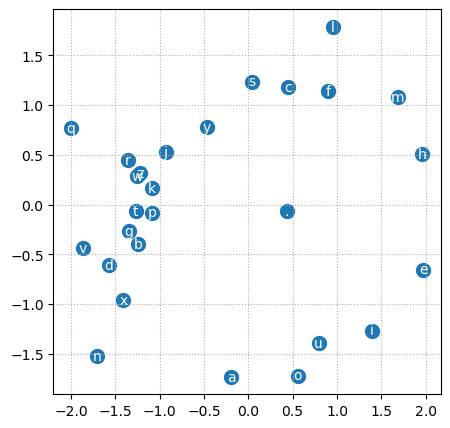

In [16]:
C=model1[0](torch.tensor(range(vocab_size)))

# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(5,5))

plt.scatter(*C.data.T, s=100)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid(ls=':')

**B.** to generate from the model, start with a context of '...'

    context = torch.tensor([[0]*block_size]).

The probabilities for the next character are calculated as 

    probs = F.softmax(model(context), dim=-1)
    
and a next character can be drawn (as in lec27) via

    idx_next = torch.multinomial(probs, num_samples=1).item()

and appended to what will ultimately be the output.

The context is updated by removing the first character and adding the new one

    context = torch.tensor([context[0][1:].tolist() + [idx_next]])
    
and the generation should stop if idx_next == 0, since that signifies the ending '.'
Use an outer loop of range(20) to generate twenty samples, they might look something like this:

    adylea.
    bilkaleona.
    kamia.
    korey.
    aria.
    ...

which, while some are not names, could conceivably be names, certainly compared with what the model generates before training:

    hpzryyn.
    bcjmeycettpguxgfxzpntrqmzoyluywberqxxyyyi.
    aovcelqk.
    qokhzmnbejbsxgytoevjdyojoaz.
    am.
    ...
    

In [17]:
n_names = 20
for i in range(n_names):
    context = torch.tensor([[0]*block_size])
    idx = torch.Tensor()
    idx_next = -1
    while(idx_next != 0):
        probs = F.softmax(model1(context), dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1).item()
        idx = torch.cat((idx, torch.tensor([idx_next])), dim=0)
        context = torch.tensor([context[0][1:].tolist() + [idx_next]])
    print(''.join(itos[i.item()] for i in idx))

meamalavesan.
nnid.
enslyn.
mar.
miza.
jori.
mak.
alaruh.
kavi.
tan.
welian.
amariteya.
parisace.
braya.
dolte.
mareilan.
rahyon.
fujn.
rayriegmoliy.
lee.


**C.** **i.** Now increase the size of the embedding dimension to `n_embd=10`, which should give better performance (`n_embd=2` was just for visualization). The test loss should come down to the $< 2.1$ range.

In [18]:
block_size = 3
n_embd = 10
vocab_size = 27
h_layer = 200

model2 = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(30,200),
    nn.ReLU(),
    nn.Linear(200, vocab_size)
)

learning_rate = .001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [19]:
for t in range(100000):
    ix = torch.randint(0, len(X_train), (batch_size,))
    optimizer.zero_grad()
    logits = model2(X_train[ix])
    loss =loss_fn(logits, y_train[ix])
    
    loss.backward()
    optimizer.step()
    
    if t % 5000 == 0 or t == 99999:
        print(f'epoch: {t} || loss: {round(loss.item(),3)}')
              
        
t_logits = model2(X_test)
test_loss = F.cross_entropy(t_logits, y_test)
f'Test Loss: {round(test_loss.item(), 3)}'

epoch: 0 || loss: 3.262
epoch: 5000 || loss: 2.107
epoch: 10000 || loss: 2.318
epoch: 15000 || loss: 2.297
epoch: 20000 || loss: 1.823
epoch: 25000 || loss: 1.931
epoch: 30000 || loss: 2.076
epoch: 35000 || loss: 1.798
epoch: 40000 || loss: 1.835
epoch: 45000 || loss: 2.092
epoch: 50000 || loss: 2.108
epoch: 55000 || loss: 2.194
epoch: 60000 || loss: 2.208
epoch: 65000 || loss: 1.831
epoch: 70000 || loss: 2.268
epoch: 75000 || loss: 2.246
epoch: 80000 || loss: 2.455
epoch: 85000 || loss: 2.066
epoch: 90000 || loss: 2.083
epoch: 95000 || loss: 2.091
epoch: 99999 || loss: 1.869


'Test Loss: 2.388'

**ii.** It doesn't make sense to plot the first two dimensions of the embedding, but now you can run a `PCA()` reduction on the 27 10-dimensional embedding vectors and plot the first two principal components (as in ps5, use a `scalar()` to normalize the data beforehand). How does it compare to the plot above?<br>
(Note that [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) turned out to work slightly better for this.)

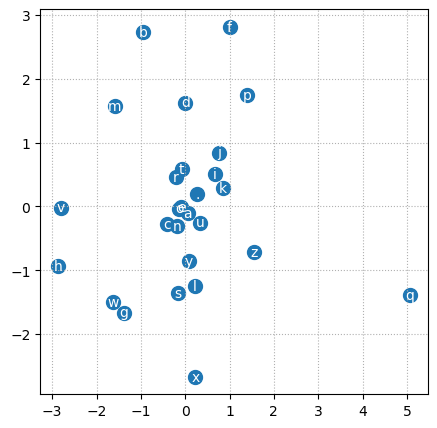

In [20]:
C1 = model2[0](torch.tensor(range(vocab_size)))
scaler = preprocessing.StandardScaler()
C1_scaled = scaler.fit_transform(C1.detach().numpy())
pca = PCA(2)
C1_new = pca.fit_transform(C1_scaled)

# Visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(5, 5))
plt.scatter(C1_new[:, 0], C1_new[:, 1], s=100)

for i in range(C1.shape[0]):
    plt.text(C1_new[i, 0], C1_new[i, 1], itos[i], ha="center", va="center", color='white')

plt.grid(ls=':')
plt.show()

**iii.** Generate 20 examples. There might be only subtle differences, but see how they compare to the earlier.

In [21]:
n_names = 20
for i in range(n_names):
    context = torch.tensor([[0]*block_size])
    idx = torch.Tensor()
    idx_next = -1
    while(idx_next != 0):
        probs = F.softmax(model2(context), dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1).item()
        idx = torch.cat((idx, torch.tensor([idx_next])), dim=0)
        context = torch.tensor([context[0][1:].tolist() + [idx_next]])
    print(''.join(itos[i.item()] for i in idx))

ton.
juhia.
cedisy.
sie.
jourtley.
amiah.
kyla.
tith.
teyani.
stah.
livia.
marcely.
laura.
rystin.
dayla.
roya.
chik.
ritzcy.
ley.
rodyn.


**D.** **i.** Train a model with `blocksize=4` (you'll need to generate new training data), and calculate the loss on the test set.  Generate 20 examples -- it might now look more constrained (and less creative), based on predicting from preceding four characters.

In [22]:
# read in all the words, I called it ak_names.txt, call it what you like
words = open('names.txt', 'r').read().splitlines()
len(words), words[:8]

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words)))) # 26 characters
stoi = {s:i+1 for i,s in enumerate(chars)}  # string to integer conversion
stoi['.'] = 0  # add in '.' for padding and for end of name
itos = {i:s for s,i in stoi.items()}  # integer back to string
print(itos)

# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# import random
# random.seed(42)
# random.shuffle(words)  #instead use in original order

n1 = int(0.8*len(words)) #80% train
n2 = int(0.9*len(words)) #10% validation / dev

X_train, y_train = build_dataset(words[:n1]) #80%
X_dev, y_dev = build_dataset(words[n1:n2])  #10%
X_test, y_test = build_dataset(words[n2:])  #10%

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
torch.Size([182778, 4]) torch.Size([182778])
torch.Size([22633, 4]) torch.Size([22633])
torch.Size([22735, 4]) torch.Size([22735])


In [23]:
block_size = 4
n_embd = 10
vocab_size = 27
h_layer = 200

model3 = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(40,200),
    nn.ReLU(),
    nn.Linear(200, vocab_size)
)

learning_rate = .001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [24]:
for t in range(100000):
    ix = torch.randint(0, len(X_train), (batch_size,))
    optimizer.zero_grad()
    logits = model3(X_train[ix])
    loss =loss_fn(logits, y_train[ix])
    
    loss.backward()
    optimizer.step()
    
    if t % 5000 == 0 or t == 99999:
        print(f'epoch: {t} || loss: {round(loss.item(),3)}')
              
        
t_logits = model3(X_test)
test_loss = F.cross_entropy(t_logits, y_test)
f'Test Loss: {round(test_loss.item(), 3)}'

epoch: 0 || loss: 3.373
epoch: 5000 || loss: 2.008
epoch: 10000 || loss: 2.321
epoch: 15000 || loss: 2.239
epoch: 20000 || loss: 1.95
epoch: 25000 || loss: 1.87
epoch: 30000 || loss: 1.76
epoch: 35000 || loss: 2.289
epoch: 40000 || loss: 2.502
epoch: 45000 || loss: 1.595
epoch: 50000 || loss: 2.001
epoch: 55000 || loss: 1.602
epoch: 60000 || loss: 2.19
epoch: 65000 || loss: 2.246
epoch: 70000 || loss: 2.154
epoch: 75000 || loss: 1.964
epoch: 80000 || loss: 1.76
epoch: 85000 || loss: 2.072
epoch: 90000 || loss: 2.011
epoch: 95000 || loss: 1.991
epoch: 99999 || loss: 2.147


'Test Loss: 2.357'

In [25]:
n_names = 20
for i in range(n_names):
    context = torch.tensor([[0]*block_size])
    idx = torch.Tensor()
    idx_next = -1
    while(idx_next != 0):
        probs = F.softmax(model3(context), dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1).item()
        idx = torch.cat((idx, torch.tensor([idx_next])), dim=0)
        context = torch.tensor([context[0][1:].tolist() + [idx_next]])
    print(''.join(itos[i.item()] for i in idx))

taelani.
koynette.
avan.
corisa.
mann.
carta.
jerrah.
deamee.
amar.
britt.
camdee.
emil.
jlaida.
adaleigan.
kayzlee.
zeena.
codinclay.
bromiah.
jsurenna.
yanah.


**ii.** Train a model with `blocksize=1` (again with new training data), and calculate the loss on the test set.  Generate 20 examples -- some might still remain reasonable but less constrained (predicting only based on preceding character), so there might be more unreasonable outliers.

In [26]:
# read in all the words, I called it ak_names.txt, call it what you like
words = open('names.txt', 'r').read().splitlines()
len(words), words[:8]

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words)))) # 26 characters
stoi = {s:i+1 for i,s in enumerate(chars)}  # string to integer conversion
stoi['.'] = 0  # add in '.' for padding and for end of name
itos = {i:s for s,i in stoi.items()}  # integer back to string
print(itos)

# build the dataset
block_size = 1 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# import random
# random.seed(42)
# random.shuffle(words)  #instead use in original order

n1 = int(0.8*len(words)) #80% train
n2 = int(0.9*len(words)) #10% validation / dev

X_train, y_train = build_dataset(words[:n1]) #80%
X_dev, y_dev = build_dataset(words[n1:n2])  #10%
X_test, y_test = build_dataset(words[n2:])  #10%

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
torch.Size([182778, 1]) torch.Size([182778])
torch.Size([22633, 1]) torch.Size([22633])
torch.Size([22735, 1]) torch.Size([22735])


In [27]:
block_size = 1
n_embd = 10
vocab_size = 27
h_layer = 200

model4 = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(),
    nn.Linear(10,200),
    nn.ReLU(),
    nn.Linear(200, vocab_size)
)

learning_rate = .001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=learning_rate)

In [28]:
for t in range(100000):
    ix = torch.randint(0, len(X_train), (batch_size,))
    optimizer.zero_grad()
    logits = model4(X_train[ix])
    loss =loss_fn(logits, y_train[ix])
    
    loss.backward()
    optimizer.step()
    
    if t % 5000 == 0 or t == 99999:
        print(f'epoch: {t} || loss: {round(loss.item(),3)}')
              
        
t_logits = model4(X_test)
test_loss = F.cross_entropy(t_logits, y_test)
f'Test Loss: {round(test_loss.item(), 3)}'

epoch: 0 || loss: 3.301
epoch: 5000 || loss: 2.438
epoch: 10000 || loss: 2.432
epoch: 15000 || loss: 2.397
epoch: 20000 || loss: 2.484
epoch: 25000 || loss: 2.367
epoch: 30000 || loss: 2.468
epoch: 35000 || loss: 2.423
epoch: 40000 || loss: 2.162
epoch: 45000 || loss: 2.495
epoch: 50000 || loss: 2.485
epoch: 55000 || loss: 2.526
epoch: 60000 || loss: 2.196
epoch: 65000 || loss: 2.107
epoch: 70000 || loss: 2.395
epoch: 75000 || loss: 2.649
epoch: 80000 || loss: 2.309
epoch: 85000 || loss: 2.394
epoch: 90000 || loss: 2.34
epoch: 95000 || loss: 2.673
epoch: 99999 || loss: 2.438


'Test Loss: 2.603'

In [29]:
n_names = 20
for i in range(n_names):
    context = torch.tensor([[0]*block_size])
    idx = torch.Tensor()
    idx_next = -1
    while(idx_next != 0):
        probs = F.softmax(model4(context), dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1).item()
        idx = torch.cat((idx, torch.tensor([idx_next])), dim=0)
        context = torch.tensor([context[0][1:].tolist() + [idx_next]])
    print(''.join(itos[i.item()] for i in idx))

a.
l.
zarindate.
iver.
cavitonn.
keria.
chambah.
saneydemayvelisariexn.
d.
sahase.
bialioya.
siy.
ja.
cylinoen.
waynllysin.
de.
ebon.
vohesey.
a.
zuli.


**E.** How many parameters are trained for each of the four models in A, B, C.i, C.ii ?

In [30]:
for layer in model1.parameters():
    print(layer.shape, np.prod(layer.shape))

torch.Size([27, 2]) 54
torch.Size([200, 6]) 1200
torch.Size([200]) 200
torch.Size([27, 200]) 5400
torch.Size([27]) 27


In [31]:
for layer in model2.parameters():
    print(layer.shape, np.prod(layer.shape))

torch.Size([27, 10]) 270
torch.Size([200, 30]) 6000
torch.Size([200]) 200
torch.Size([27, 200]) 5400
torch.Size([27]) 27


In [32]:
for layer in model3.parameters():
    print(layer.shape, np.prod(layer.shape))

torch.Size([27, 10]) 270
torch.Size([200, 40]) 8000
torch.Size([200]) 200
torch.Size([27, 200]) 5400
torch.Size([27]) 27


In [33]:
for layer in model4.parameters():
    print(layer.shape, np.prod(layer.shape))

torch.Size([27, 10]) 270
torch.Size([200, 10]) 2000
torch.Size([200]) 200
torch.Size([27, 200]) 5400
torch.Size([27]) 27


## 2) [bonus]

Train a model of the same form as above, but using Karpathy's "tiny shakespeare" dataset as in lec27. You'll now need `vocab_size=65`, and you may want to adjust some of the other parameters of the model, depending on your compute resources. (E.g., a larger vocabulary size might benefit from a larger embedding dimension `n_embd`, 30 seemed to work OK) The training data can be sampled as above, in `batch_size` chunks of length `block_size` drawn at random from the text, or you can use a dataloader as in ps7 and cycle systemically through all the data once per epoch.

If the former, the `get_batch()` function from the lec27 notebook needs the simple modification that the y values are now just the single next character for each sample, `y = torch.stack([data[i+block_size] for i in ix])`.

For `block_size = 2,3,4`, what is the loss, and generate some text to (qualitatively...) assess its quality.

You could also PCA (or t-SNE) reduce the new character embeddings down to two principle components for visualization.
